[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/MOOC_Notebooks/Notebook05_Train_ANNs.ipynb)

# Notebook 05: Train ANNs

Authors: Randy J. Chase, David R. Harrison, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks and Deep Learning](https://arxiv.org/abs/2211.00147)<br>
Original Github: [WAF_ML_Tutorial_Part2](https://github.com/ai2es/WAF_ML_Tutorial_Part2)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Lackmann, G. M., & McGovern, A. (2023). A Machine Learning Tutorial for Operational Meteorology. Part II: Neural Networks and Deep Learning, 	arXiv:2211.00147.

### Primary Goal: Train and evaluate the artifical neural networks 

#### Background

In the paper we start by training artifical neural networks, so we will do the same here in the notebooks. 

Note that the model used in the paper is included in the github repository, but we will also take you through the steps to build and train a similar network here.

#### Step 0: Install packages and grab data

Note: downloading the data can take up to 15-20 mins depending on the server speed. Please be patient

In [ ]:
#@title Install and unpack files [this will take some time]

print('installing dependancies')
!pip -q install zenodo-get
!pip -q install zarr 
print('grabbing sub-sevir')
!zenodo_get 7011372
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')

#### Step 1: Imports

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np 
import tqdm 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]


#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False
%config InlineBackend.figure_format = 'retina'

#one quick thing here, we need to set the random seed so we all get the same results no matter the computer or python session 
tf.random.set_seed(43)

#### Step 2: Load data

In [2]:
#load training 
df_t = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_train.csv')
#load validation set
df_v = pd.read_csv('/content/WAF_ML_Tutorial_Part2/datasets/sub-sevir-engineered/lowres_features_val.csv')

#make matrices for training/validation
X_t = df_t.to_numpy()[:,:36]
y_t = df_t.to_numpy()[:,36]
X_v = df_v.to_numpy()[:,:36]
y_v = df_v.to_numpy()[:,36]

#### Step 3: Make tensorflow dataset 

As we discussed in the previous notebook, we need to shuffle and batch the data. We will leverage the ```tf.data.Datasets```

In [3]:
#make datasets 
ds_train = tf.data.Dataset.from_tensor_slices((X_t,y_t))
ds_val = tf.data.Dataset.from_tensor_slices((X_v,y_v))

#shuffle only the training 
ds_train = ds_train.shuffle(ds_train.cardinality().numpy())

#batch both 
batch_size = 32
ds_train = ds_train.batch(batch_size)
ds_val = ds_val.batch(batch_size)

2022-12-13 11:54:41.644480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Just a few quick notes on batching: First, we technically do not need to batch the validation data. The reason we do so here is to save time/RAM when computing the predictions on the validation data. Second, it is important to carefully choose how much data to include within a single batch. If your batch is too small, it could take many interations to train the model. Conversely, a batch that is too large can overwelm your RAM. As such, the optimal batch size will be machine dependent. 

#### Step 4: Build a model

In the paper we note that neural networks do not have a "one size fits all" paradigm, where a set of default parameters can consistently achieve good results. With neural networks you *need* to do some sort of hyperparameter search. So here, while we only show one model configuration, we encourage you to play around with different model configurations to figure out what hyperparameters work best for a given prediction task. In fact, we have a modular script that leverages the tensorflow api to help optimize your model configurations. The notebook example explaining this script is [here](#) <-- dead link right now!

Let's start simple and create a model with 2 layers with 2 neurons each to classify whether or not an example contains lightning (0 no lightning, 1 lightning). 



In [4]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Dense(2,activation='relu',input_shape=(X_t.shape[1],),),
        #hidden layer 1
        tf.keras.layers.Dense(2,activation='relu'),
        #output layer 
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 74        
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


Notice the following about the above definition of the model: 

1. The input layer *always* has the input_shape defined

    - This is needed so that the model is initialized with the correct number of weights. Otherwise you won't see the summary output above. 


2. The activation functions for the input and hidden layers are 'relu' 

    - Tensorflow models do not have an activation function by default (i.e., $\sigma(x) = x$), which is why we didn't mention them in the previous notebook.  However, NNs require an activation function to effectively learn non-linear relationships in the data.  The 'relu' activation function is commonly used for this purpose. 

3. The output layer (last layer) has a *sigmoid* activation function 

    - This is specifically for classification tasks. If we were training a regression model (as in the previous notebook), we wouldn't need this (i.e., linear activation). 
    - If you have more than one output neuron (say if you have more than two possible classifications such as 'no lightning', 'some lightning', and 'lots of lightning'), then you would use *softmax* instead of sigmoid. 


#### Step 5: Run some data through it

In order to visualize the initial performance with random weights and biases, we can plug the data into the untrained model and plot a performance diagram. But first let's look at the raw model output:

(0.0, 1.0)

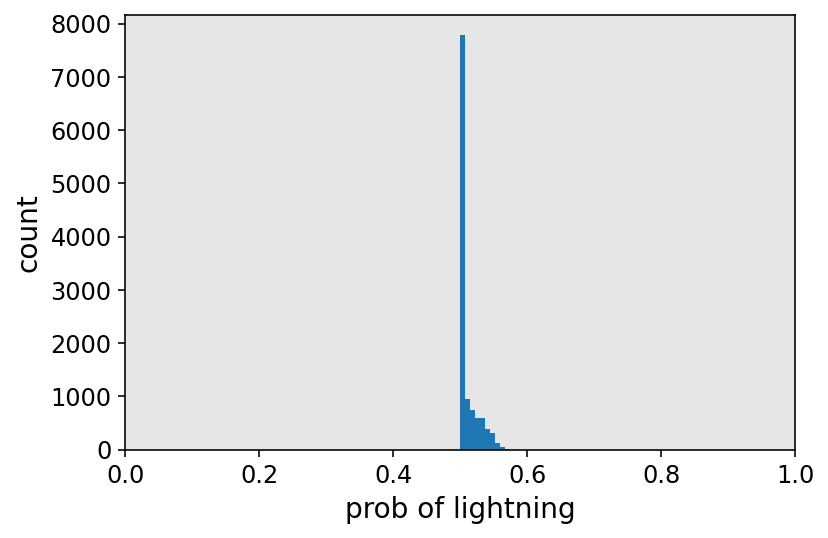

In [5]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

The sigmoid function in the output layer ensures that all model output falls between 0 - 1. In order to plot the performance diagram, we can use some fun tensorflow pre-built metrics:

In [6]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


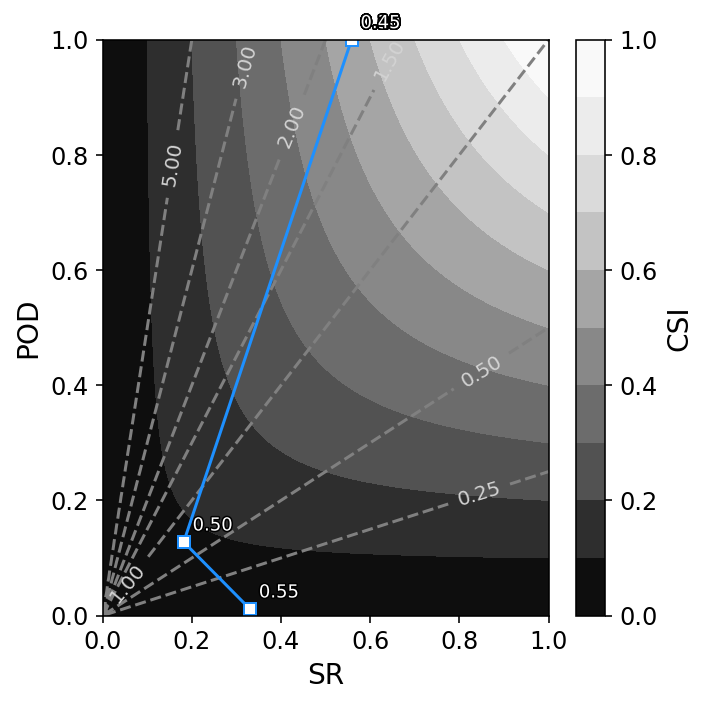

In [7]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()


As expected, the model performance looks wonky! It is an untrained model. 

#### Step 6: Train the model 

Okay, let's get the model compiled and train it for 25 epochs. 

In [8]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

history = model.fit(ds_train,validation_data=ds_val,epochs=25)

Epoch 1/25
1875/1875 [==============================] - 2s 703us/step - loss: 0.4991 - val_loss: 0.4118
Epoch 2/25
1875/1875 [==============================] - 1s 662us/step - loss: 0.3092 - val_loss: 0.3229
Epoch 3/25
1875/1875 [==============================] - 1s 654us/step - loss: 0.2725 - val_loss: 0.2946
Epoch 4/25
1875/1875 [==============================] - 1s 655us/step - loss: 0.2581 - val_loss: 0.2859
Epoch 5/25
1875/1875 [==============================] - 1s 661us/step - loss: 0.2514 - val_loss: 0.2727
Epoch 6/25
1875/1875 [==============================] - 1s 653us/step - loss: 0.2479 - val_loss: 0.2690
Epoch 7/25
1875/1875 [==============================] - 1s 659us/step - loss: 0.2459 - val_loss: 0.2603
Epoch 8/25
1875/1875 [==============================] - 1s 663us/step - loss: 0.2445 - val_loss: 0.2633
Epoch 9/25
1875/1875 [==============================] - 1s 731us/step - loss: 0.2435 - val_loss: 0.2692
Epoch 10/25
1875/1875 [==============================] - 1s 711u


#### Step 7: Check for overfitting

Notice that there is a new parameter in the ```.fit``` command. Specifically, we have passed the validation data to the function so that the validation loss can be computed and displayed as the model trains. Additionally, we also set the model.fit command equal to a variable called ```history```. This enables us to plot the data that is being outputed in the text above. 

This data is very useful for determining if a model is overfitting. Let's plot the training loss vs the validation loss: 

Text(0, 0.5, 'loss')

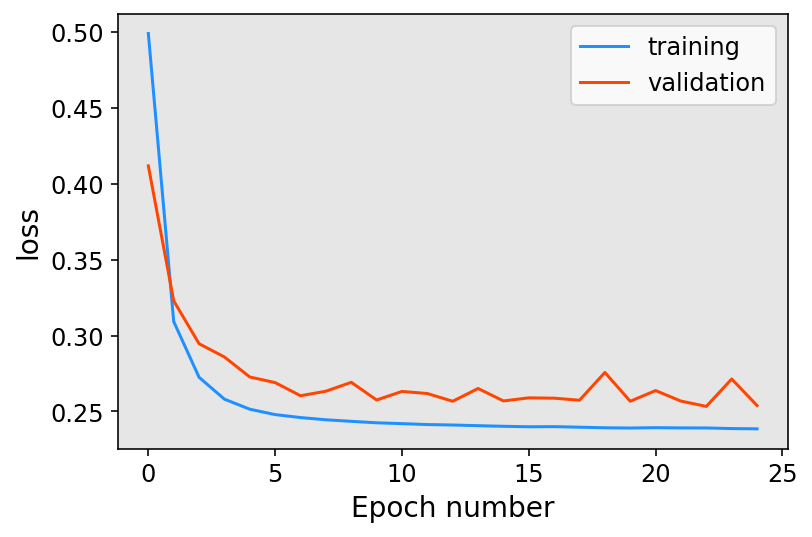

In [9]:
plt.plot(history.history['loss'],color='dodgerblue',label='training')
plt.plot(history.history['val_loss'],color='orangered',label='validation')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('loss')

Above, you want to compare the red line to the blue line. The absolute value is less important. Notice that the red line is relatively flat after about 10 epochs. This isn't much of an overfitting signal, which would be increasing validation loss with more epochs, but it does seem to have converged to some local minimum. 

#### Step 8: Check validation performance

Now that the model is trained, let's check the new predictions and generate the performance diagram: 

Text(0, 0.5, 'count')

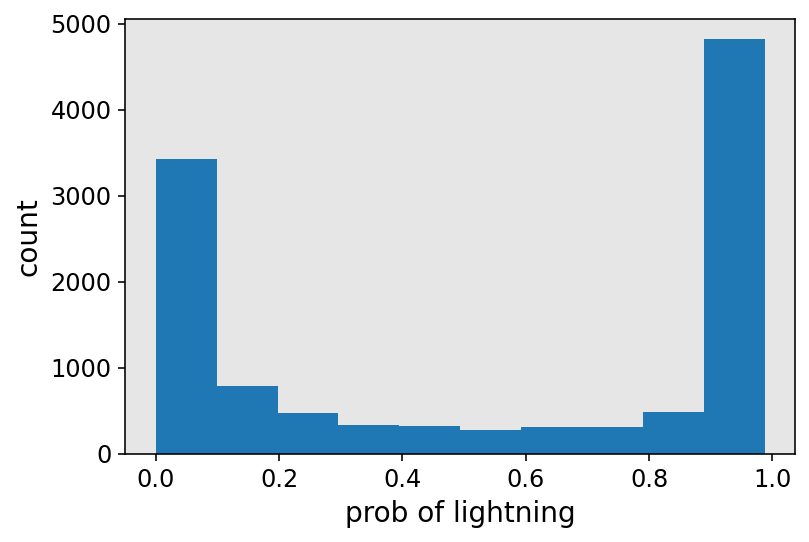

In [10]:
#like sklearn, we do .predict!
y_preds = model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')

Well this looks better than before, and we can see that there is a good number of predictions near 1 (lightning) and 0 (no lightning). Hopefully these predictions align with the correct 'truth' labels. Let's take a look at the performance diagram.

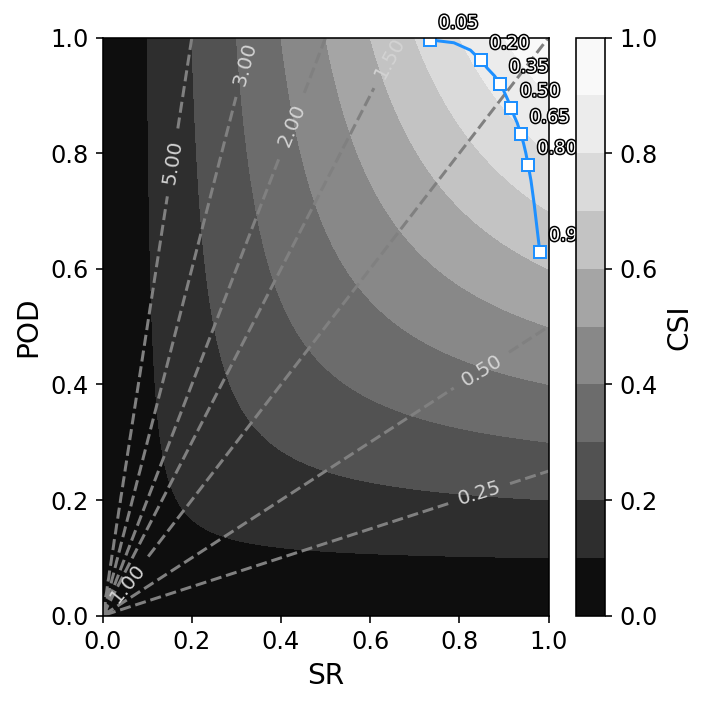

In [11]:
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    #plot text and marker every 3rd point, because every point was too many
    if np.mod(i,3) == 0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.plot(np.asarray(srs)[i],np.asarray(pods)[i],'s',color='dodgerblue',markerfacecolor='w')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

MUCH BETTER. Even just a simple neural network does well here. This is probably because the task is relative easy - remember that we could use a simple brightness temperature threshold for IR to get an 80% accuracy.
A quick note about the performance diagram: Each marker represents the model's performance when using a certain probability value as the decision threshold. That is, we can say an example contains lightning if the model produces a probability of at least 5%, 10%, 20%, etc.  In this example, the model acheveed the greatest CSI and lowest bias with a probability threshold of about 36%. This probability threshold could then be used to convert the model's probabilistic output into an optimized deterministic prediction.

Because this network is so small, we can actually view the learned weights and biases of each layer. These numbers will not be meaniful to us, but it can be useful to check that all layers are working correctly.

In [12]:
model.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(36, 2) dtype=float32, numpy=
 array([[-1.55337825e-01,  3.46964777e-01],
        [-1.02038145e-01,  3.59163672e-01],
        [ 2.13905454e-01,  2.62565285e-01],
        [-1.46155640e-01,  5.88695481e-02],
        [ 1.20497406e-01, -9.30148438e-02],
        [-2.20156953e-01, -1.11497484e-01],
        [-2.20726639e-01,  1.70682780e-02],
        [-1.12678796e-01, -1.13547407e-02],
        [-3.24822664e-01, -9.91298333e-02],
        [-1.47997946e-01,  2.60586381e-01],
        [-7.23532289e-02, -3.17085117e-01],
        [-2.80567110e-01, -1.32511696e-02],
        [ 6.56924322e-02, -5.02323359e-02],
        [ 2.23927066e-01, -5.56745604e-02],
        [ 5.75579643e-01,  1.18782580e-01],
        [ 9.67578664e-02, -2.00778097e-01],
        [-1.15805440e-01,  2.67483205e-01],
        [ 1.67067140e-01, -3.03277344e-01],
        [ 8.35941285e-02, -7.29657784e-02],
        [ 2.30207264e-01, -2.53861666e-01],
        [ 1.19015761e-01,  9.85671133e-02],
        [

In [13]:
model.layers[1].weights

[<tf.Variable 'dense_1/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.2371206, 1.1020488],
        [1.6244591, 2.0011137]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([0.00047399, 0.00051893], dtype=float32)>]

#### Step 9: Save trained model

Now that you have a model trained, you probably don't want to re-train it every time you need to make a prediction. So to save the trained model, we can do the following:

In [14]:
model.save('/content/WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_notebooks/MyFirstNN.h5')

This saves the trained model to a *containerized* and *portable* hdf5 file. There are also ways to save just the weights from specific training steps, but that's  beyond the scope of this tutorial. If you are interested in learning more, check out this help guide: [https://www.tensorflow.org/tutorials/keras/save_and_load](https://www.tensorflow.org/tutorials/keras/save_and_load). 

#### Step 11: Load trained model

It's just as easy to load the model back in.

In [15]:
loaded_model = tf.keras.models.load_model('/content/WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_notebooks/MyFirstNN.h5',compile=False)

The extra input to this line, ```compile=False```, helps avoid conflicts with custom functions that you may have used during training. In general, tensorflow seems to complain less when using this flag, and if you don't need to re-train the model, this is the easiest way to get it loaded. 

#### Step 12: Run loaded model

Now it's all set to run!

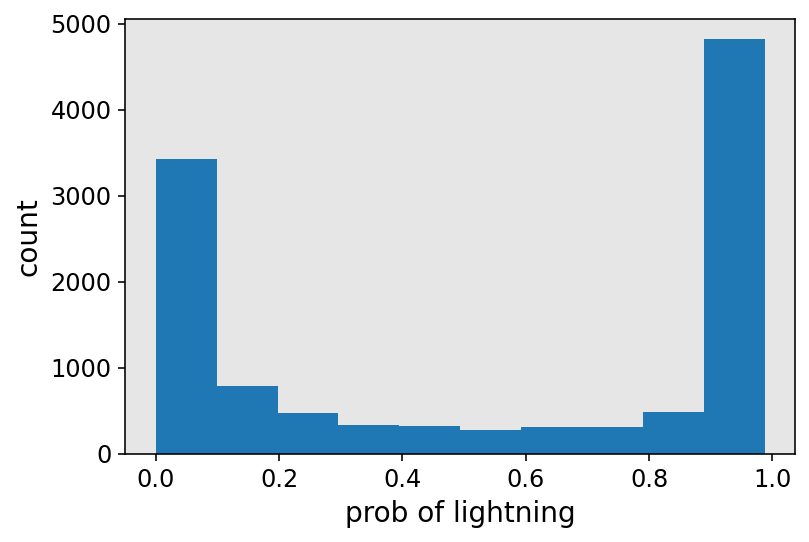

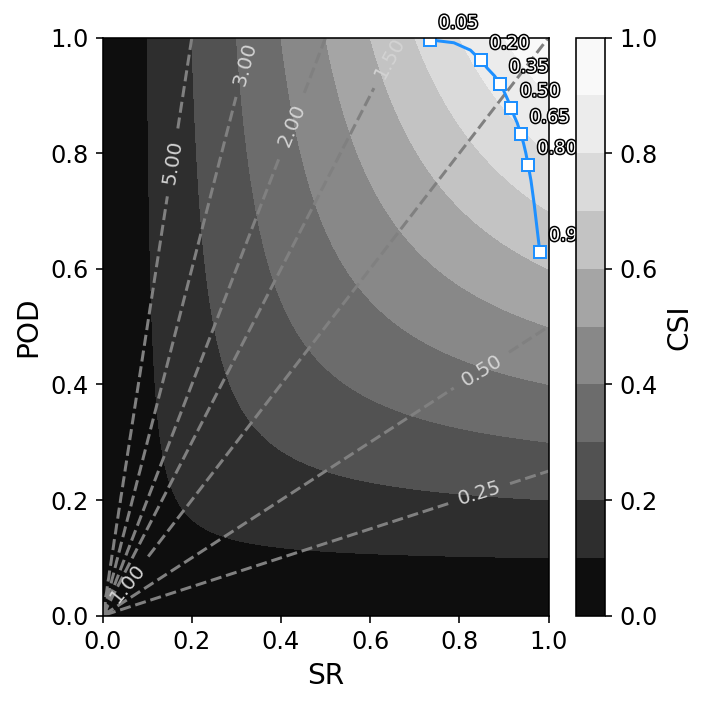

In [16]:
#like sklearn, we do .predict!
y_preds = loaded_model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    #plot text and marker every 3rd point, because every point was too many
    if np.mod(i,3) == 0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.plot(np.asarray(srs)[i],np.asarray(pods)[i],'s',color='dodgerblue',markerfacecolor='w')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

#### Step 13: Load and run the network from the paper

You can even load and run the network demonstrated in the paper:

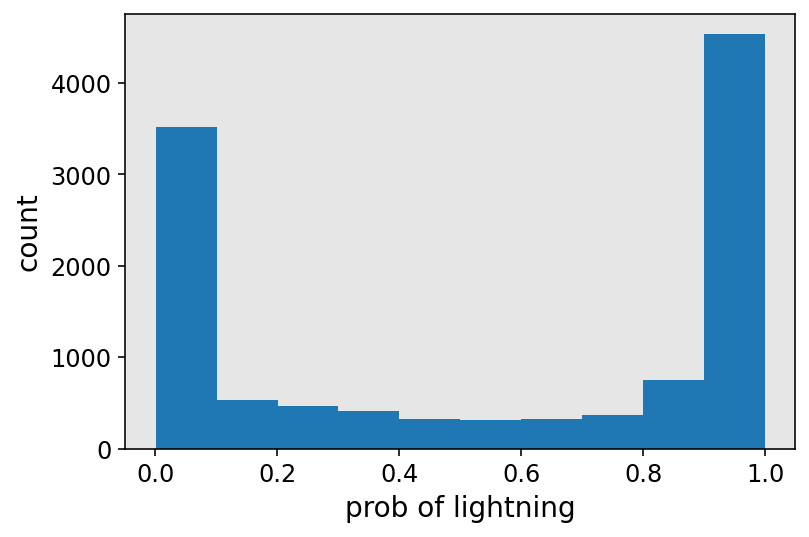

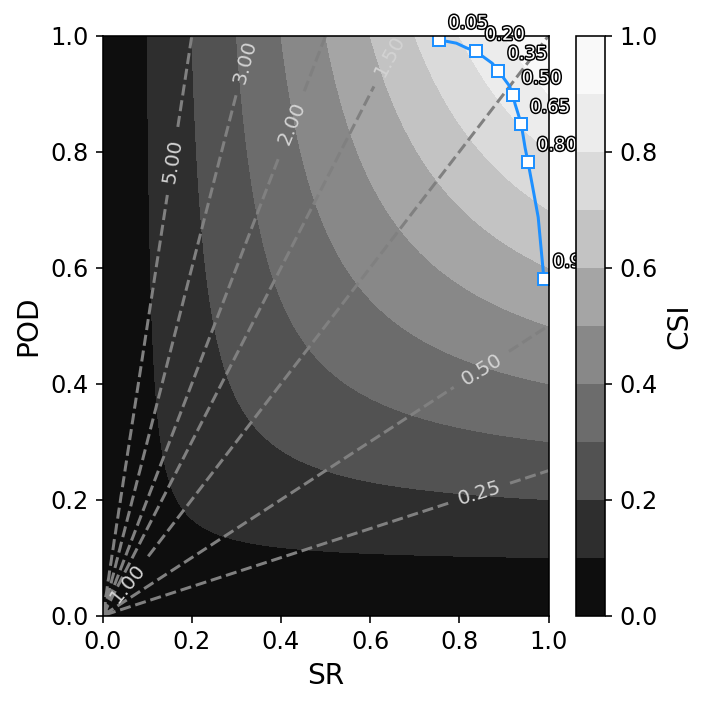

In [17]:
paper_model = tf.keras.models.load_model('/content/WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_paper/sub-sevir-ann-class-1d-eng.h5',compile=False)

#like sklearn, we do .predict!
y_preds = paper_model.predict(ds_val)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v,y_preds)
fps = fp(y_v,y_preds)
fns = fn(y_v,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    #plot text and marker every 3rd point, because every point was too many
    if np.mod(i,3) == 0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.plot(np.asarray(srs)[i],np.asarray(pods)[i],'s',color='dodgerblue',markerfacecolor='w')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

volia! Now you can hopefully do end-to-end neural networks. The next notebook will jump into convolutions.